# Import statements

In [18]:
# Necessary imports
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple

# For visualization
from IPython.display import HTML
from IPython import display 
import glob

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# Necessary functions for generating scenario and creating the environment

In [19]:
#Function for normal distribution truncation:

from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#Function to get observation (still for single env, need to modify for multi-agent env):

def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

#Function to get the one-hot-encoded vectors for departure and arrival airports:

def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

# Example usage
num_airports = 2
airport1 = 0
airport2 = 1

encoded_airport1 = one_hot_encode_airport(airport1, num_airports)
encoded_airport2 = one_hot_encode_airport(airport2, num_airports)

print(encoded_airport1)
print(encoded_airport2)

#Generate full info for the arrival sides:

def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][4]/5
        if ts_arv[i] > 287:
            ts_arv[i] = ts_arv[i] - 287
    return ts_arv

#Generate the multi-agent scenario:

#=======================================================

#Modify the distribution based on historical data later:
def generate_scenario(number_of_requests, num_airports, cap_dict):
    
    #number_of_requests = 15000
    ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate index for requests:

    index = np.array(list(range(number_of_requests)))

    #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):

    #num_airports = 3
    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    destination_airport = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range(number_of_requests):
        _org_airport = one_hot_encode_airport(random.randint(0,1), num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
        #Generate destination (the destination will be different with the origin):
        _dest_airport = _org_airport.copy()
        while np.array_equal(_dest_airport, _org_airport):
            np.random.shuffle(_dest_airport)
        _dest_airport_list = _dest_airport.tolist()
        destination_airport[i] = _dest_airport_list

    #Generate flying time (assume between airport 0 and 1 is 2 hour, 0 to 2 and 1 to 2 is arbitrary):

    fly_time = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range (number_of_requests):
        if origin_airport[i] == list([1.0, 0.0]) and destination_airport[i] == list([0.0, 1.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([0.0, 1.0]) and destination_airport[i] == list([1.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])

    #Generate status cap:

    status_cap_dep = np.full((number_of_requests,), 0)
    status_cap_arv = np.full((number_of_requests,), 0)
    

    requests = np.stack((index, ts_dep, origin_airport, destination_airport, fly_time, status_cap_dep), axis=1)

    #Generate full info for the arv side:

    ts_arv = generate_info_arv(requests)

    #pseudo_belong_dep = np.full((number_of_requests,), 0)
    #pseudo_belong_arv = np.full((number_of_requests,), 0)
    
    # Define requests_full as dtype object
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 8), dtype=object)
    # Fill the array
    data = [index, ts_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, status_cap_arv]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    # airport_req_dict: A dictionary where each key corresponds to a specific airport's requirements. 
    # The key format is 'req_i', where i is the index of the airport. 
    # The value for each key is a numpy array, with each row representing a request and the columns containing different attributes of that request.
    airport_req_dict, _belong_airport_dict = get_airport_req_dict(requests_full, num_airports)

    pot_dem_dict = get_initial_pot_dem_per_airport(airport_req_dict, num_airports)

    cap_dem_dict = get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict)

    return requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict

def flatten_cap_dem_dict(cap_dem_dict, num_airports):
    cap_dem_dict_flat = {}
    for i in range(num_airports):
        cap_dem_dict_flat['req_{}'.format(i)] = cap_dem_dict['req_{}'.format(i)].flatten()
    return cap_dem_dict_flat

#Get separated req per airport and store in a dict:

def get_airport_req_dict(requests_full, num_airports):
    airport_req_dict = {}
    _belong_airport_dict = {}
    for i in range(num_airports):
        airport_req_dict['req_{}'.format(i)] = np.empty((0, 10)) #This one depends on the number of elements of a final request
        _belong_airport_dict['req_{}'.format(i)] = np.full(num_airports, 0.0, dtype=float)
        _belong_airport_dict['req_{}'.format(i)][i] = float(1.0)
        _belong_airport_dict['req_{}'.format(i)] = _belong_airport_dict['req_{}'.format(i)].tolist()
        
    for i in range(len(requests_full)):
        _found_dep = 0
        _found_arv = 0
        for k in range(num_airports):
            #_found_dep = 0
            #_found_arv = 0
            if requests_full[i][2] == _belong_airport_dict['req_{}'.format(k)]:
                _dep_req = np.append(requests_full[i], 1)
                _dep_req = np.append(_dep_req, 0)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _dep_req))
                _found_dep = 1

            if requests_full[i][3] == _belong_airport_dict['req_{}'.format(k)]:
                _arv_req = np.append(requests_full[i], 0)
                _arv_req = np.append(_arv_req, 1)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _arv_req))
                _found_arv = 1

            if _found_dep + _found_arv == 2:
                break
        if _found_dep + _found_arv != 2:
            print("Cannot found both dep and arv at req {}".format(i))
    
    return airport_req_dict, _belong_airport_dict

def generate_deterministic_capacity_dict(num_airports, cap_per_airport_arr): #This function is for 288 slots/ day
    cap_dict = {}
    for i in range(num_airports):
        cap_dict['req_{}'.format(i)] = np.full((288), cap_per_airport_arr[i])
    return cap_dict

def get_date_plot(timeslot_movements, i):
    indices, items = zip(*timeslot_movements)
    sum_of_values = sum(item[1] for item in timeslot_movements)
    print("no of request: ", sum_of_values)
    plt.figure(figsize=(10,6))
    plt.bar(indices, items, width=3.0) 
 
    plt.xlabel('Timeslot') 
    plt.ylabel('No. of movements') 

    plt.title('No. of movements by timeslot in airport' +  str(i)) 

    plt.show()

def get_initial_pot_dem_per_airport(airport_req_dict, num_airports): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_dict = {}
    #TODO: increase speed
    #8 dep 9 arv, 1 dep ts, 6 arv ts
    for i in range(num_airports):
        pot_dem_dict['req_{}'.format(i)] = np.full((288), 0)
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][8]) + int(airport_req_dict['req_{}'.format(i)][k][6]) * int(airport_req_dict['req_{}'.format(i)][k][9])
            pot_dem_dict['req_{}'.format(i)][_time_slot] += 1

    for i in range(num_airports):
        indexed_array = [[index, item] for index, item in enumerate(pot_dem_dict['req_{}'.format(i)])]
        get_date_plot(indexed_array, i)
        
    return pot_dem_dict

def get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict):
    cap_dem_dict = {}
    for i in range(num_airports):
        cap_dem_dict['req_{}'.format(i)] = cap_dict['req_{}'.format(i)] - pot_dem_dict['req_{}'.format(i)]
    return cap_dem_dict

def update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
    for i in range(num_airports):
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][8]) + int(airport_req_dict['req_{}'.format(i)][k][6]) * int(airport_req_dict['req_{}'.format(i)][k][9])
            # Ensure that cap_dem_dict['req_{}'.format(i)][_time_slot] is an iterable (e.g., a numpy array or a list)
            cap_dem_values = cap_dem_dict['req_{}'.format(i)][_time_slot]
            
            if isinstance(cap_dem_values, (np.ndarray, list)) and all(x >= 0 for x in cap_dem_values):
                airport_req_dict['req_{}'.format(i)][k][5] = 0
                airport_req_dict['req_{}'.format(i)][k][7] = 0
            else:
                if airport_req_dict['req_{}'.format(i)][k][8] == 1:
                    airport_req_dict['req_{}'.format(i)][k][5] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 5] = 1
                else:
                    airport_req_dict['req_{}'.format(i)][k][7] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 7] = 1

[1. 0.]
[0. 1.]


-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# DQN Algorithm Code

In [20]:
# Define Neural Network for Q Network
class QNetwork(nn.Module):
    # Initilize parameters to build model
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    # Build a network that maps state to action values
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [21]:
# Define the hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-2               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
# Define the agent
class Agent():
    # Initialize the Agent object
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    # Function to return actions for the given state based on the current policy
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # change this to just take random action and return the action after mapping
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    # Function to return actions for test
    def pred(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # self.qnetwork_local.eval()
        # with torch.no_grad():
        action_values = self.qnetwork_local(state)
        return np.argmax(action_values.cpu().data.numpy())

    # Update the value parameters based on the given batch of experience tuples
    def learn(self, experiences, gamma):

        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        # Compute and minimize the loss
        # Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        # Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [24]:
# Define the Replay Buffer
class ReplayBuffer:
    # Initialize the Replay Buffer
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    # Add a new experience
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # Randomly sample a batch of experiences from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# [VALIDATION] Simulator Environment for 2 airports

In [25]:
class TestTwoAirportSchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_requests, num_airports, cap_per_airport_arr):
        super(TestTwoAirportSchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions)
        self.number_of_requests = number_of_requests
        self.num_airports = num_airports
        self.cap_per_airport_arr = cap_per_airport_arr
        self.cap_dict = generate_deterministic_capacity_dict(self.num_airports, self.cap_per_airport_arr)
        _exceed_cap = 0         
        while _exceed_cap == 0:
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests = self.number_of_requests, num_airports = self.num_airports, cap_dict = self.cap_dict)
            self.cap_dem_dict_flat = flatten_cap_dem_dict(self.cap_dem_dict, self.num_airports)
            for i in range(num_airports):
                _exceed_cap = _exceed_cap + (min(self.cap_dem_dict_flat['req_{}'.format(i)]))

        #to generate action:
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.observation_space = spaces.Box(low= -np.inf, high= np.inf, shape=(7,), dtype=float)
        self.violate_set = self.get_violate_id_set(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.num_step = 0
        
        #to choose the request that will be checked
        self.get_req(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        
        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print("Number of unaccomodated requests for generated scenario:", _unaccom_req)
        
        self.original_requests = self.requests_full
    
    def action_mapping(self, action, number_of_actions):
        mid_point = (number_of_actions - 1) // 2
        return action - mid_point
    
    #added get request to know which is the request we are going to move at this step",
    #Randomly choose a violating request to solve
    def get_req(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):

        if not self.violate_set:
          self.violate_set = self.get_violate_id_set(airport_req_dict, num_airports, cap_dem_dict, requests_full)
          if not self.violate_set:
            self.chosen_req = None 
            return self.chosen_req 

        airport_num, airport_index, request_violate_index = random.choice(self.violate_set)
        valid = self.check_status_capacity(airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_violate_index)

        while not valid:

          if not self.violate_set:
            self.violate_set = self.get_violate_id_set(airport_req_dict, num_airports, cap_dem_dict, requests_full)
            if not self.violate_set:
              self.chosen_req = None 
              return self.chosen_req 

          airport_num, airport_index, request_violate_index = random.choice(self.violate_set)
          valid = self.check_status_capacity(airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_violate_index)

        self.chosen_req = self.requests_full[self.requests_full[:,0] == request_violate_index][0]

        return self.chosen_req
    
    #need to check arrival time or change the variable to check_outbound(arv) and chec_outbound(dep)
    def check_outbound(self, action):
        dep_time_slot = self.chosen_req[1]
        arv_time_slot = self.chosen_req[6]

        outbound = False

        new_dep_time_slot = dep_time_slot + action
        new_arv_time_slot = arv_time_slot + action

        if (new_dep_time_slot < 0) or (new_dep_time_slot > 287) or (new_arv_time_slot < 0) or (new_arv_time_slot > 287):
            outbound = True

        return outbound
    
    def dep_or_arv(self):
        pass

    def update_dem(self, dep_airport, arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        # Increment demand for the new time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][new_time_slot_dep] += 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][new_time_slot_arv] += 1

        # Decrease demand for the initial time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][time_slot_dep] -= 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][time_slot_arv] -= 1

    def update_cap_dem(self):
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            if cap_key not in self.cap_dict:
                raise KeyError(f"'{cap_key}' not found in cap_dict. Available keys: {list(self.cap_dict.keys())}")
            self.cap_dem_dict[cap_key] = self.cap_dict[cap_key] - self.pot_dem_dict[dem_key]

    def check_status_capacity(self, airport_req_dict, cap_dem_dict, requests_full, airport_num, airport_index, request_index):

        ts_dep = int(requests_full[request_index, 1])
        ts_arv = int(requests_full[request_index, 6])
        origin_airport = int(requests_full[request_index, 2].index(1.0))
        destination_airport = int(requests_full[request_index, 3].index(1.0))

        if (airport_num, airport_index, request_index) in self.violate_set:
            self.violate_set.remove((airport_num, airport_index, request_index))

        cap_dem_values = []
        cap_dem_values.append(cap_dem_dict['req_{}'.format(origin_airport)][ts_dep])
        cap_dem_values.append(cap_dem_dict['req_{}'.format(destination_airport)][ts_arv])
        if isinstance(cap_dem_values, (np.ndarray, list)) and all(x >= 0 for x in cap_dem_values):
            airport_req_dict['req_{}'.format(airport_num)][airport_index][5] = 0
            airport_req_dict['req_{}'.format(airport_num)][airport_index][7] = 0
            requests_full[request_index, 5] = 0
            requests_full[request_index, 7] = 0

            valid = False
        else:
            if airport_req_dict['req_{}'.format(airport_num)][airport_index][8] == 1:
                airport_req_dict['req_{}'.format(airport_num)][airport_index][5] = 1
                requests_full[request_index, 5] = 1
            else:
                airport_req_dict['req_{}'.format(airport_num)][airport_index][7] = 1
                requests_full[request_index, 7] = 1

            valid = True

        return valid

    def get_airport_index(self, airport_type):
        # Check for airport type
        if airport_type == "departure":
            airport_index = self.chosen_req[2].index(1.0)
        elif airport_type == "arrival":
            airport_index = self.chosen_req[3].index(1.0)
        else:
            raise ValueError(f"Invalid airport_type: {airport_type}. Expected 'departure' or 'arrival'.")

        return airport_index
    
    def update_status_capacity(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
        not_violate_update = set()
        violate_update = set()
        for i in range(num_airports):
            for k in range(len(airport_req_dict['req_{}'.format(i)])):
                _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][8]) + int(airport_req_dict['req_{}'.format(i)][k][6]) * int(airport_req_dict['req_{}'.format(i)][k][9])
                cap_dem_values = cap_dem_dict['req_{}'.format(i)][_time_slot]

                # THis if statement line could be a problem, if the cap_dem_values is not an instance of np.ndarray or list, then it won't be accessed
                if isinstance(cap_dem_values, (np.ndarray, list)) and all(x >= 0 for x in cap_dem_values):
                # if all(x >= 0 for x in cap_dem_dict['req_{}'.format(i)][_time_slot]):
                    if airport_req_dict['req_{}'.format(i)][k][5] == 1 or airport_req_dict['req_{}'.format(i)][k][7] == 1:
                        not_violate_update.add(airport_req_dict['req_{}'.format(i)][k][0])
                    airport_req_dict['req_{}'.format(i)][k][5] = 0
                    airport_req_dict['req_{}'.format(i)][k][7] = 0
                else:
                    if airport_req_dict['req_{}'.format(i)][k][5] == 0 and airport_req_dict['req_{}'.format(i)][k][7] == 0:
                        violate_update.add(airport_req_dict['req_{}'.format(i)][k][0])
                    if airport_req_dict['req_{}'.format(i)][k][8] == 1:
                        airport_req_dict['req_{}'.format(i)][k][5] = 1
                        _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                        requests_full[_indices, 5] = 1
                    else:
                        airport_req_dict['req_{}'.format(i)][k][7] = 1
                        _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                        requests_full[_indices, 7] = 1

        return not_violate_update, violate_update

    def get_violate_id_set(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
        self.update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full)
        violate_set = [] #(1: id, 2: airport, 3: dep, 4: arv)
        for i in range(num_airports):
            for k in range(len(airport_req_dict['req_{}'.format(i)])):
                if airport_req_dict['req_{}'.format(i)][k][5] + airport_req_dict['req_{}'.format(i)][k][7] >= 1:
                    violate_set.append((i, k, airport_req_dict['req_{}'.format(i)][k][0]))

        return violate_set

    def timeslot_print_statements(self, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        print("Original departure timeslot for request : ", time_slot_dep)
        print("Original arrival timeslot for request : ", time_slot_arv)
        print("New departure timeslot for request : ", new_time_slot_dep)
        print("New arrival timeslot for request : ", new_time_slot_arv)

    def outbound_print_statements(self, new_time_slot_dep, new_time_slot_arv):
        print("Slot outbound, adjusted new departure timeslot for request", new_time_slot_dep)
        print("Slot outbound, adjusted new arrival timeslot for request", new_time_slot_arv)

    def dem_bef_action_print_statements(self, _dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        print("Initial departure time slot demand before action is taken: ", self.pot_dem_dict['req_{}'.format(_dep_airport)][time_slot_dep])
        print("Initial arrival time slot demand before action is taken: ", self.pot_dem_dict['req_{}'.format(_arv_airport)][time_slot_arv])
        print("New departure time slot demand before action is taken: ", self.pot_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep])
        print("New arrival time slot demand before action is taken: ", self.pot_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv])

    def dem_aft_action_print_statements(self, _dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        print("Initial departure time slot demand after action is taken: ", self.pot_dem_dict['req_{}'.format(_dep_airport)][time_slot_dep])
        print("Initial arrival time slot demand after action is taken: ", self.pot_dem_dict['req_{}'.format(_arv_airport)][time_slot_arv])
        print("New departure time slot demand after action is taken: ", self.pot_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep])
        print("New arrival time slot demand after action is taken: ", self.pot_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv])

    def capdem_bef_action_print_statements(self, _dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        print("Initial departure time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_dep_airport)][time_slot_dep])
        print("Initial arrival time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_arv_airport)][time_slot_arv])
        print("New departure time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep])
        print("New arrival time slot remaining capacity before action is taken: ", self.cap_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv])

    def capdem_aft_action_print_statements(self, _dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv):
        print("Initial departure time slot remaining capacity after action is taken: ", self.cap_dem_dict['req_{}'.format(_dep_airport)][time_slot_dep])
        print("Initial arrival time slot remaining capacity after action is taken: ", self.cap_dem_dict['req_{}'.format(_arv_airport)][time_slot_arv])
        print("New departure time slot remaining capacity after action is taken: ", self.cap_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep])
        print("New arrival time slot remaining capacity after action is taken: ", self.cap_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv])

    def aft_action_print_statements(self, chosen_req, requests_full, _index, airport_req_dict, _dep_airport, _arv_airport):
        print("chosen request status capacity after action is taken for departure airport: ", chosen_req[5])
        print("chosen request status capacity after action is taken for arrival airport: ", chosen_req[7])
        print("Request information in full request list after action is taken", requests_full[requests_full[:, 0] == _index])
        print("request status capacity in full request list after action is taken for departure airport: ", requests_full[requests_full[:, 0] == _index][:, 5])
        print("request status capacity in full request list after action is taken for arrival airport: ", requests_full[requests_full[:, 0] == _index][:, 7])
        # print("departure airport request after action is taken: ", airport_req_dict['req_{}'.format(_dep_airport)][airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index])
        # print("arrival airport request after action is taken: ", airport_req_dict['req_{}'.format(_arv_airport)][airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index])
        # print("departure airport request status capacity for departure after action is taken: ", airport_req_dict['req_{}'.format(_dep_airport)][airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 5])
        # print("arrival airport request status capacity for departure after action is taken: ", airport_req_dict['req_{}'.format(_arv_airport)][airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 5])
        # print("departure airport request status capacity for arrival after action is taken: ", airport_req_dict['req_{}'.format(_dep_airport)][airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 7])
        # print("arrival airport request status capacity for arrival after action is taken: ", airport_req_dict['req_{}'.format(_arv_airport)][airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 7])
    
    def when_take_action(self, action):   
        _index = self.chosen_req[0]
        time_slot_dep = self.chosen_req[1]
        time_slot_arv = self.chosen_req[6]
        time_slot_arv = int(time_slot_arv)
        _dep_airport = self.chosen_req[2].index(1.0)
        _arv_airport = self.chosen_req[3].index(1.0)
        new_time_slot_dep = time_slot_dep + action
        new_time_slot_arv = time_slot_arv + action
        new_time_slot_arv = int(new_time_slot_arv)
        
        self.timeslot_print_statements(time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)

        outbound = self.check_outbound(action)

        if not outbound:
            pass
            
        elif outbound:
            # new_time_slot_dep = random.randint(0, 287)
            # new_time_slot_arv = random.randint(0, 287)
            new_time_slot_dep = time_slot_dep
            new_time_slot_arv = time_slot_arv
            self.outbound_print_statements(new_time_slot_dep, new_time_slot_arv)

        else:
            print('Problem with check outbound!')

        print("Request information in full request list before action is taken", self.requests_full[self.requests_full[:, 0] == _index])

        # Update the chosen request for both departure and arrival time slots
        self.chosen_req[1] = new_time_slot_dep
        self.chosen_req[6] = new_time_slot_arv
            
        # # [NOT WORKING] Update the full request list for both departure and arrival time slots
        # print("Request information in full request list before action is taken", self.requests_full[self.requests_full[:, 0] == _index])
        # self.requests_full[self.requests_full[:, 0] == _index][:, 1] = new_time_slot_dep
        # self.requests_full[self.requests_full[:, 0] == _index][:, 6] = new_time_slot_arv

        # # [NOT WORKING] Update the airport request dict
        # print("departure airport request before action is taken: ", self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index])
        # print("arrival airport request before action is taken: ", self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index])
        # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 6] = new_time_slot_arv
        # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 6] = new_time_slot_arv

        # Update demand for the new time slots
        self.dem_bef_action_print_statements(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)
        self.update_dem(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)
        self.dem_aft_action_print_statements(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)
        
        # Update cap_dem
        self.capdem_bef_action_print_statements(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)        
        self.update_cap_dem()
        self.capdem_aft_action_print_statements(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv)

        # self.update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        if self.cap_dem_dict['req_{}'.format(_dep_airport)][new_time_slot_dep] >= 0:
            self.chosen_req[5] = 0
            # #[NOT WORKING]
            # self.requests_full[self.requests_full[:, 0] == _index][:, 5] = 0
            # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 5] = 0
            # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 5] = 0
        else:
            self.chosen_req[5] = 1
            # # [NOT WORKING]
            # self.requests_full[self.requests_full[:, 0] == _index][:, 5] = 1
            # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 5] = 1
            # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 5] = 1

        if self.cap_dem_dict['req_{}'.format(_arv_airport)][new_time_slot_arv] >= 0:
            self.chosen_req[7] = 0
            # # [NOT WORKING]
            # self.requests_full[self.requests_full[:, 0] == _index][:, 7] = 0
            # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 7] = 0
            # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 7] = 0
        else:
            self.chosen_req[7] = 1
            # # [NOT WORKING]
            # self.requests_full[self.requests_full[:, 0] == _index][:, 7] = 1
            # self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 7] = 1
            # self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 7] = 1

        self.requests_full[self.requests_full[:, 0] == _index] = self.chosen_req
        self.aft_action_print_statements(self.chosen_req, self.requests_full, _index, self.airport_req_dict, _dep_airport, _arv_airport)

    def step(self, action): 
        num_actions = self.number_of_actions
        # # Convert the discrete action to your desired action value
        real_action = self.action_mapping(action, num_actions)
        print("Action taken: ", real_action)

        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print("Number of unaccomodated requests at the start of this step:", _unaccom_req)
        
        # observation concats the following:
        # ts_dep + cap_dem_dep + ts_arv + cap_dem_arv
        self.when_take_action(real_action)
        outbound = self.check_outbound(real_action)

        # Count number of remaining unaccommodated requests
        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print("Number of unaccomodated requests after this step:", _unaccom_req)

        # Reward part:
        done = False
        self.num_step += 1
        
        if outbound:
            real_action = 0
            
        if real_action != 0:
            local_reward = 0.1*(-abs(real_action)*0.5)
            print("Local Reward:", local_reward)
            
            if self.chosen_req[5] == 0 and self.chosen_req[7] == 0:
                reward_solved = 20
                print("Reward for solving current request:", reward_solved)

            else:
                reward_solved = 0
                print("Reward for solving current requests:", reward_solved)

            if _unaccom_req == 0 and self.num_step != self.number_of_requests*5:
                done = True
                self.num_step = 0
                obs = np.zeros(578)
                global_reward = 30
                print("Reward received when all requests are solved:", global_reward)

            elif self.num_step == self.number_of_requests*5:
                done = True
                self.num_step = 0
                obs = np.zeros(578)
                global_reward = _unaccom_req * -10
                print("Reward received when maximum timestep is reached:", global_reward)

            else:
                global_reward = 0
                obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
                print("Global reward received:", global_reward)
            reward_time_step = -0.5
            print("Timestep reward received:", reward_time_step)
        
        else:
            reward_time_step = -0.5
            local_reward = 0
            global_reward = 0
            reward_solved = 0
            print("Timestep reward received:", reward_time_step)
            print("Local reward received:", local_reward)
            print("Global reward received:", global_reward)
            print("Reward received for solving current request:", reward_solved)
            obs = self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)

        total_reward = float(local_reward + reward_solved + global_reward + reward_time_step)
        print("Total reward received:", total_reward)
    
        return obs, total_reward, done, {}
    
    def _next_observation(self, airport_req_dict, num_airports, cap_dem_dict, requests_full):
        self.get_req(airport_req_dict, num_airports, cap_dem_dict, requests_full)
        _ts_dep = self.chosen_req[1]
        _ts_arv = self.chosen_req[6]
        _dep_airport = self.chosen_req[2].index(1.0)
        _arv_airport = self.chosen_req[3].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]

        self.obs = np.append(_ts_dep, cap_dem_arr_dep)
        self.obs = np.append(self.obs, _ts_arv)
        self.obs = np.append(self.obs, cap_dem_arr_arv)
        
        return self.obs

    def reset(self):                
        self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
        cap_dem_arr_airport1 = self.cap_dem_dict['req_{}'.format(0)]
        cap_dem_arr_airport2 = self.cap_dem_dict['req_{}'.format(1)]
        
        _cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
        _cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()

        while (min(_cap_dem_flat_airport1) >= 0 or min(_cap_dem_flat_airport2) >= 0):
            generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
            _cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
            _cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()
        
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        print('Number of violation for airport1: ', len(_cap_dem_flat_airport1[_cap_dem_flat_airport1 < 0]))
        print('Number of violation for airport2: ', len(_cap_dem_flat_airport2[_cap_dem_flat_airport2 < 0]))

        self.num_step = 0        
        return self._next_observation(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
    
    # Need to validate
    def evaluate_metrics(self):
        _initial_cap_dem_dict = {}
        _initial_pot_dem_dict = get_initial_pot_dem_per_airport(self.airport_req_dict, self.num_airports)
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            _initial_cap_dem_dict[cap_key] = self.cap_dict[cap_key] - _initial_pot_dem_dict[dem_key]

        # Code to print initial number of violation requests for each airport agent
        _initial_cap_dem_airport1 = _initial_cap_dem_dict['req_{}'.format(0)]
        _initial_cap_dem_flat_airport1 = _initial_cap_dem_airport1.flatten()
        _initial_violate_airport1 = len(_initial_cap_dem_flat_airport1[_initial_cap_dem_flat_airport1 < 0])
        print('Initial count of unit violation for airport1 is: ', _initial_violate_airport1)
        _initial_cap_dem_airport2 = _initial_cap_dem_dict['req_{}'.format(1)]
        _initial_cap_dem_flat_airport2 = _initial_cap_dem_airport2.flatten()
        _initial_violate_airport2 = len(_initial_cap_dem_flat_airport2[_initial_cap_dem_flat_airport2 < 0])
        print('Initial count of unit violation for airport2 is: ', _initial_violate_airport2)

        # Code to print final number of violation requests for each airport agent
        cap_dem_arr_airport1 = self.cap_dem_dict['req_{}'.format(0)]
        cap_dem_arr_airport2 = self.cap_dem_dict['req_{}'.format(1)]
        _final_cap_dem_flat_airport1 = cap_dem_arr_airport1.flatten()
        _final_cap_dem_flat_airport2 = cap_dem_arr_airport2.flatten()
        _final_violate_airport1 = len(_final_cap_dem_flat_airport1[_final_cap_dem_flat_airport1 < 0])
        _final_violate_airport2 = len(_final_cap_dem_flat_airport2[_final_cap_dem_flat_airport2 < 0])
        print('Final count of unit violation for airport1 is: ', _final_violate_airport1)
        print('Final count of unit violation for airport2 is: ', _final_violate_airport2)

        # Code to print final schedule delay for each airport agent
        # What this does is it takes the absolute sum of the original time slot for request i - the updated time slot for request i
        # for each request 1
        # This is to see how much the time slots of each request has shifted 
        # Example: for request index 150, ori time slot = 10; updated time slot = 110
        # the delay for this request = |10 - 110| = 100
        _total_sched_delay_dep = sum(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        _total_sched_delay_arv = sum(abs(self.original_requests[:,6] - self.requests_full[:,6]))       
        dep_airport_index = self.get_airport_index("departure")
        arv_airport_index = self.get_airport_index("arrival")
        if dep_airport_index == 0 and arv_airport_index == 1:
            print('Total schedule delay of airport1 is: ', _total_sched_delay_dep)
            print('Total schedule delay of airport2 is: ', _total_sched_delay_arv)
        elif dep_airport_index == 1 and arv_airport_index == 0:
            print('Total schedule delay of airport1 is: ', _total_sched_delay_arv)
            print('Total schedule delay of airport2 is: ', _total_sched_delay_dep)
        else:
            print("Error in airport retrieval for total_sched_delay")

        # Code to print max shift for each airport agent
        # Among all requests, find out what is the biggest abs value of original time slot - updated time slot
        _max_shift_dep = max(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        _max_shift_arv = max(abs(self.original_requests[:,6] - self.requests_full[:,6]))
        if dep_airport_index == 0 and arv_airport_index == 1:
            print('Max shift of airport1: ', _max_shift_dep)
            print('Max shift of airport2: ', _max_shift_arv)
        elif dep_airport_index == 1 and arv_airport_index == 0:
            print('Max shift of airport1: ', _max_shift_arv)
            print('Max shift of airport2: ', _max_shift_dep)
        else:
            print("Error in airport retrieval for max_shift")

        # Code to print number of unaccommodated requests at the end of the episode
        _unaccom_req = len(self.requests_full[(self.requests_full[:, 5] == 1) | (self.requests_full[:, 7] == 1)])
        print('Number of unaccommodated requests: ', _unaccom_req)

        return _initial_violate_airport1, _initial_violate_airport2, _final_violate_airport1, _final_violate_airport2, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

# Environment Validation Loop

no of request:  1500


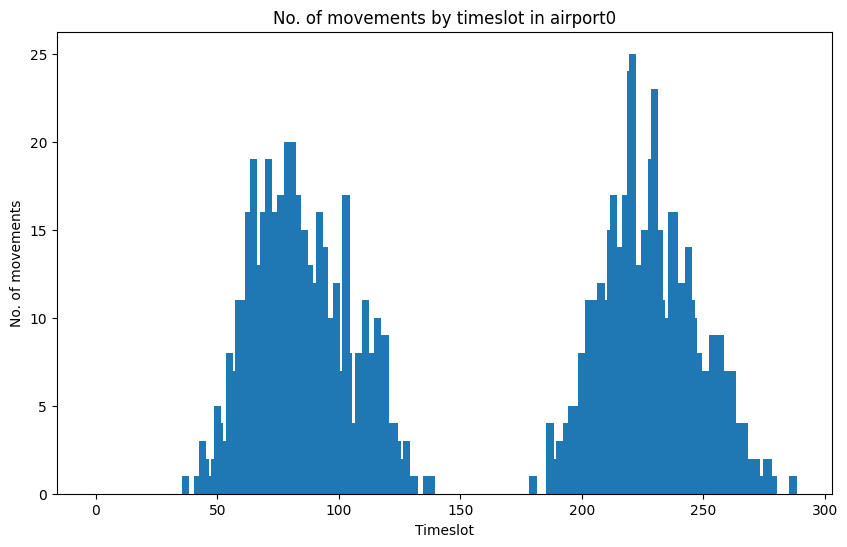

no of request:  1500


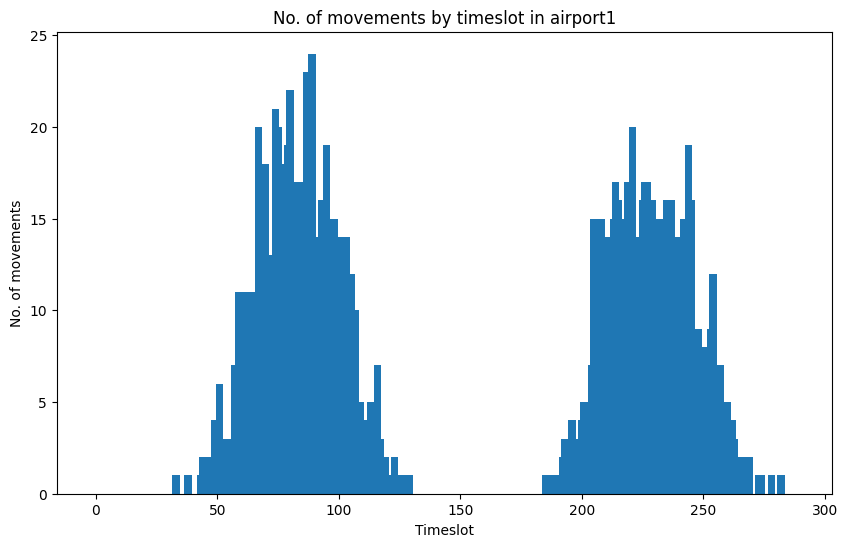

Number of unaccomodated requests for generated scenario: 1500


In [26]:
# Initialize Two Airport Scheduler environment
num_actions = 11
env = TestTwoAirportSchedEnv(number_of_actions=num_actions, number_of_requests=1500, num_airports=2, cap_per_airport_arr= [6,6])

no of request:  1500


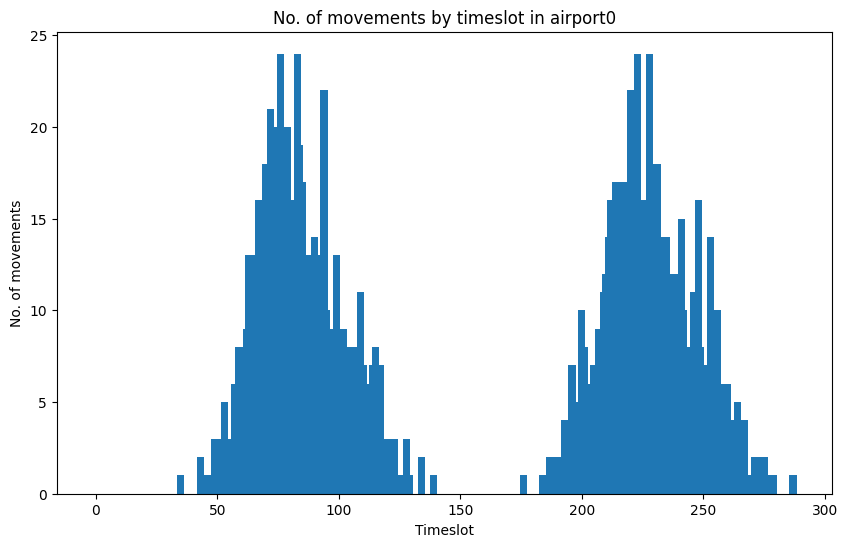

no of request:  1500


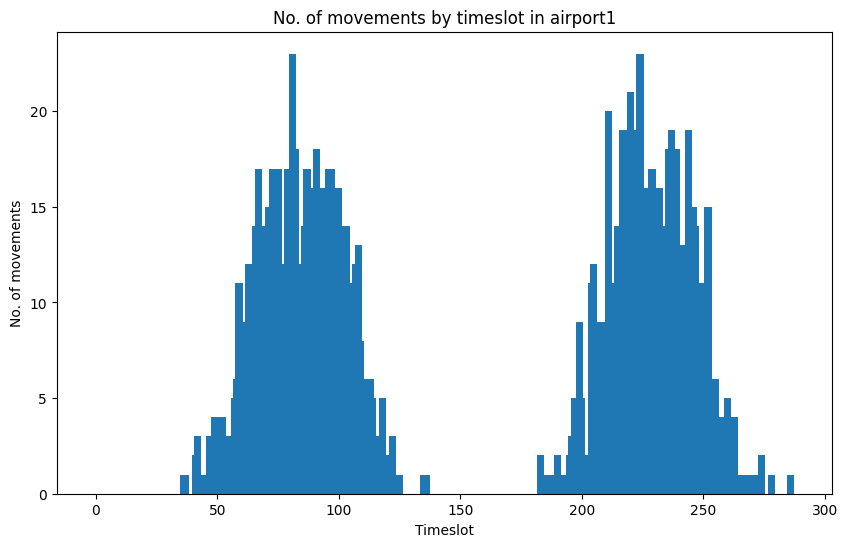

Number of violation for airport1:  99
Number of violation for airport2:  98
Action taken:  -4
Number of unaccomodated requests at the start of this step: 1500
Original departure timeslot for request :  72
Original arrival timeslot for request :  84
New departure timeslot for request :  68
New arrival timeslot for request :  80
Request information in full request list before action is taken [[359 72 list([0.0, 1.0]) list([1.0, 0.0]) 60 1 84.0 1]]
Initial departure time slot demand before action is taken:  12
Initial arrival time slot demand before action is taken:  19
New departure time slot demand before action is taken:  9
New arrival time slot demand before action is taken:  13
Initial departure time slot demand after action is taken:  11
Initial arrival time slot demand after action is taken:  18
New departure time slot demand after action is taken:  10
New arrival time slot demand after action is taken:  14
Initial departure time slot remaining capacity before action is taken:  -6


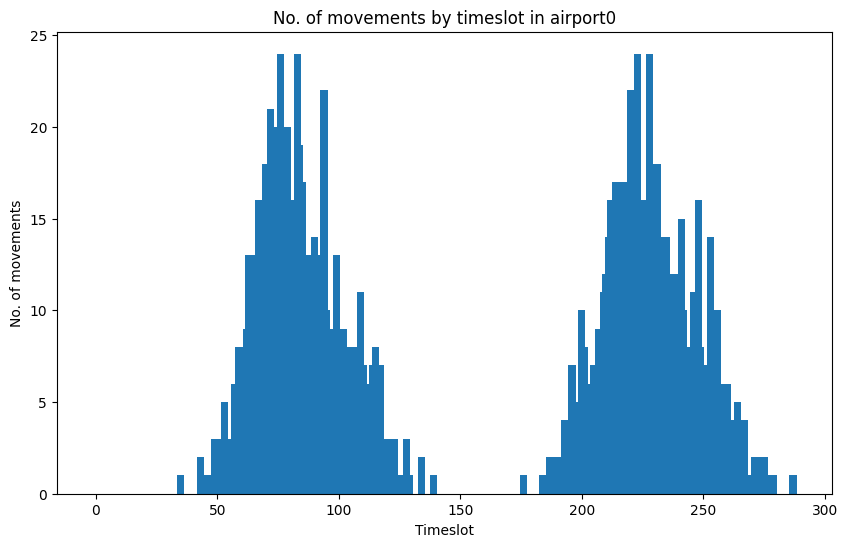

no of request:  1500


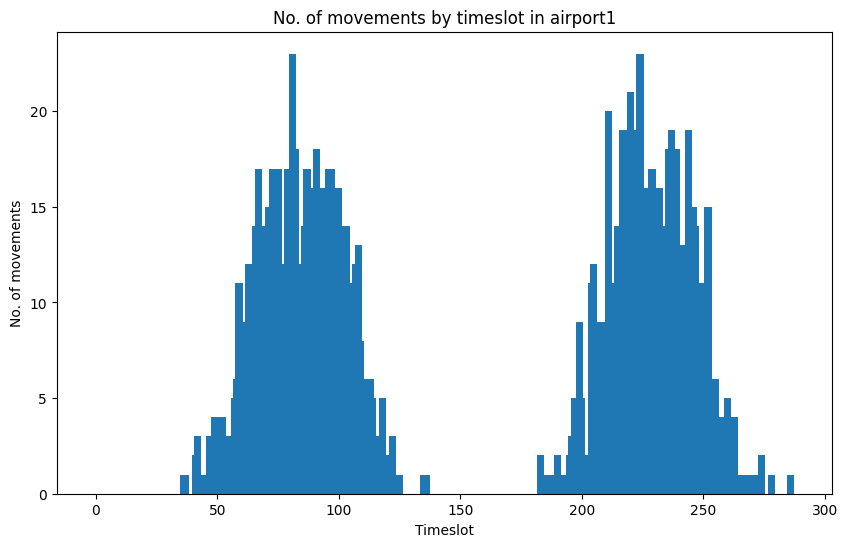

Initial count of unit violation for airport1 is:  99
Initial count of unit violation for airport2 is:  98
Final count of unit violation for airport1 is:  99
Final count of unit violation for airport2 is:  98
Total schedule delay of airport1 is:  24514.0
Total schedule delay of airport2 is:  20698
Max shift of airport1:  64.0
Max shift of airport2:  61
Number of unaccommodated requests:  1500
no of request:  1500


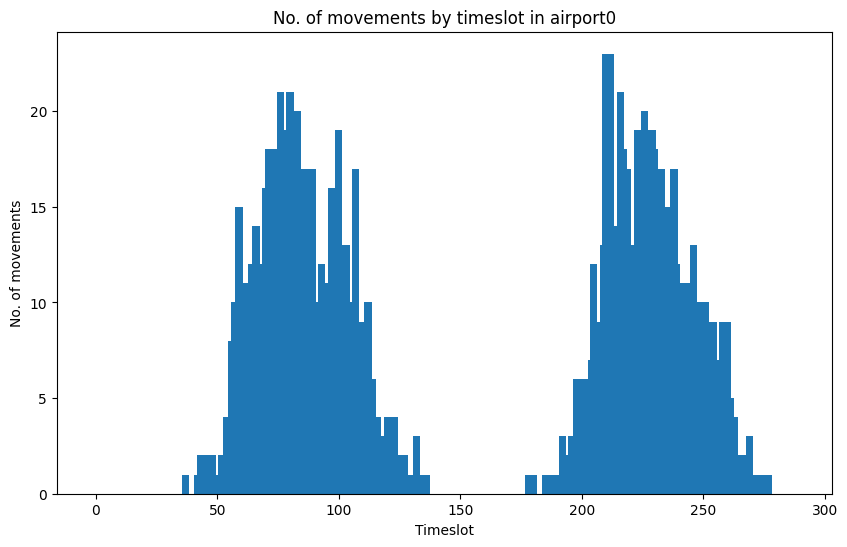

no of request:  1500


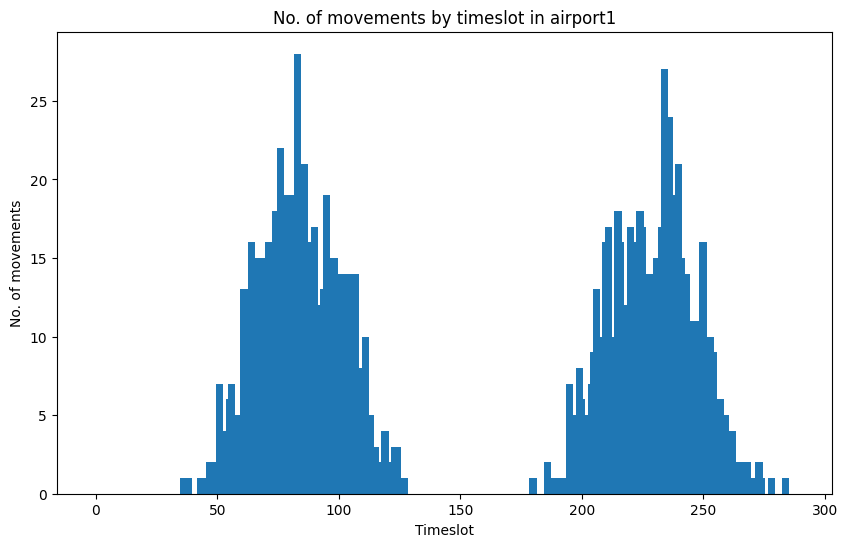

Number of violation for airport1:  102
Number of violation for airport2:  100
Action taken:  -2
Number of unaccomodated requests at the start of this step: 1500
Original departure timeslot for request :  68
Original arrival timeslot for request :  104
New departure timeslot for request :  66
New arrival timeslot for request :  102
Request information in full request list before action is taken [[399 68 list([0.0, 1.0]) list([1.0, 0.0]) 180 1 104.0 1]]
Initial departure time slot demand before action is taken:  12
Initial arrival time slot demand before action is taken:  10
New departure time slot demand before action is taken:  10
New arrival time slot demand before action is taken:  10
Initial departure time slot demand after action is taken:  11
Initial arrival time slot demand after action is taken:  9
New departure time slot demand after action is taken:  11
New arrival time slot demand after action is taken:  11
Initial departure time slot remaining capacity before action is taken

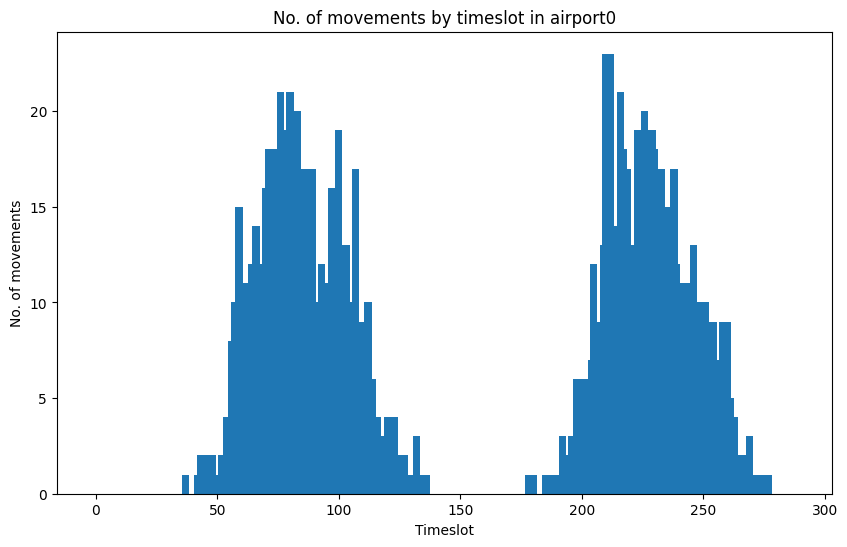

no of request:  1500


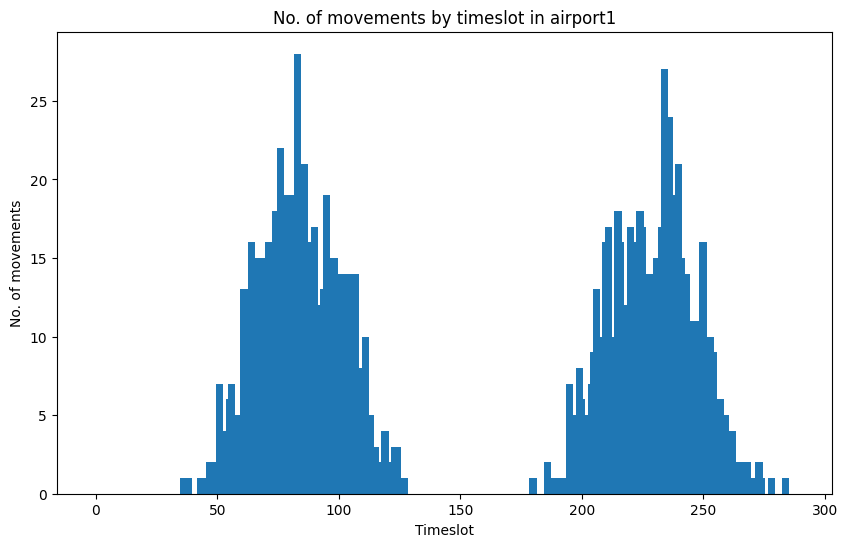

Initial count of unit violation for airport1 is:  102
Initial count of unit violation for airport2 is:  100
Final count of unit violation for airport1 is:  102
Final count of unit violation for airport2 is:  100
Total schedule delay of airport1 is:  20165
Total schedule delay of airport2 is:  23739.0
Max shift of airport1:  63
Max shift of airport2:  80.0
Number of unaccommodated requests:  1500
no of request:  1500


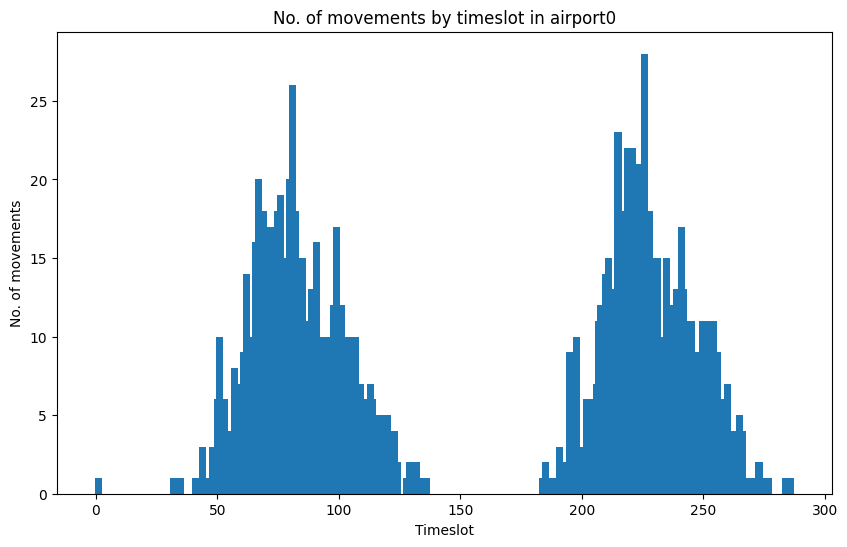

no of request:  1500


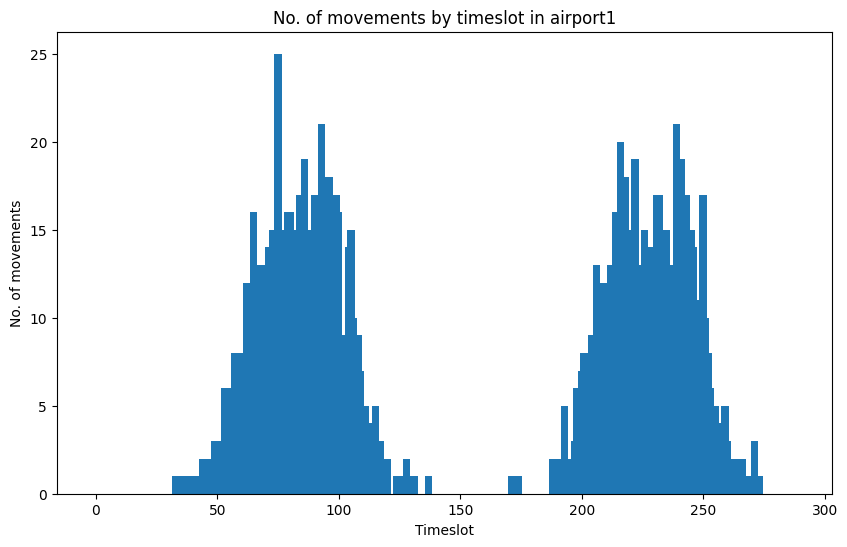

Number of violation for airport1:  100
Number of violation for airport2:  103
Action taken:  4
Number of unaccomodated requests at the start of this step: 1500
Original departure timeslot for request :  221
Original arrival timeslot for request :  233
New departure timeslot for request :  225
New arrival timeslot for request :  237
Request information in full request list before action is taken [[1136 221 list([0.0, 1.0]) list([1.0, 0.0]) 60 1 233.0 1]]
Initial departure time slot demand before action is taken:  14
Initial arrival time slot demand before action is taken:  9
New departure time slot demand before action is taken:  11
New arrival time slot demand before action is taken:  9
Initial departure time slot demand after action is taken:  13
Initial arrival time slot demand after action is taken:  8
New departure time slot demand after action is taken:  12
New arrival time slot demand after action is taken:  10
Initial departure time slot remaining capacity before action is taken

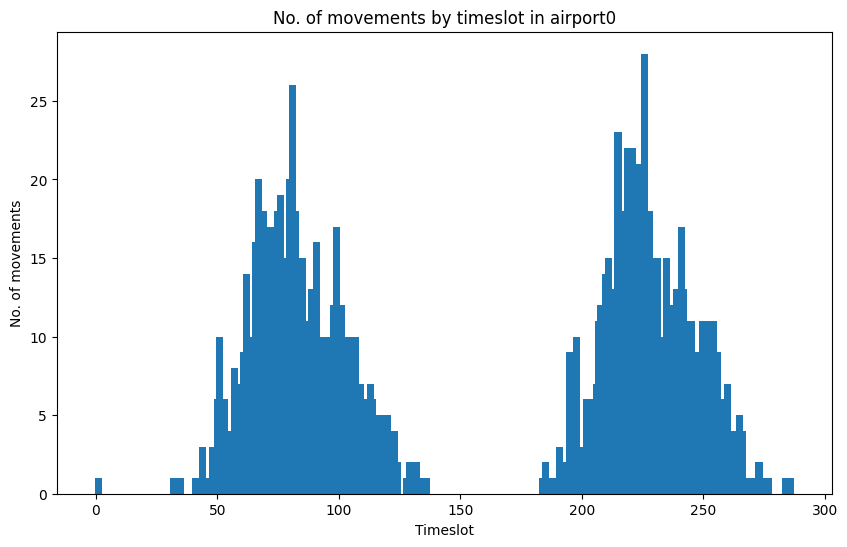

no of request:  1500


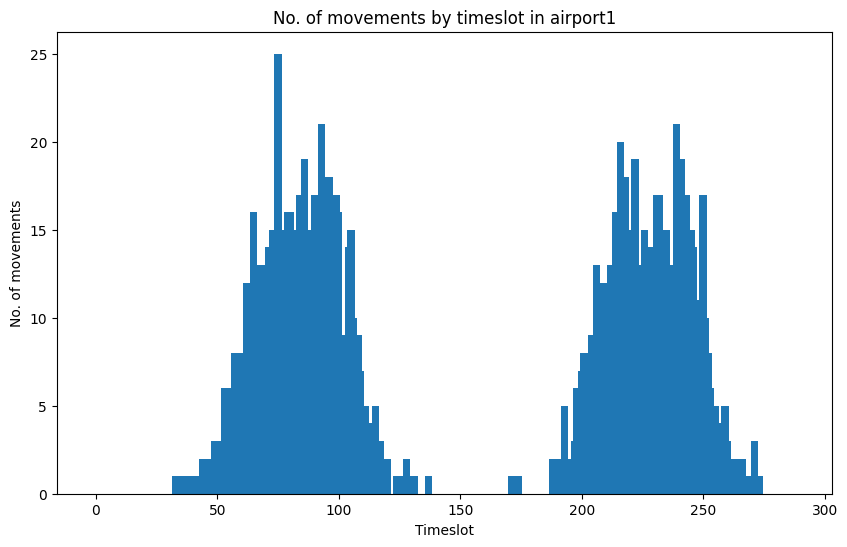

Initial count of unit violation for airport1 is:  100
Initial count of unit violation for airport2 is:  103
Final count of unit violation for airport1 is:  101
Final count of unit violation for airport2 is:  103
Total schedule delay of airport1 is:  20399
Total schedule delay of airport2 is:  23694.0
Max shift of airport1:  65
Max shift of airport2:  230.0
Number of unaccommodated requests:  1500
no of request:  1500


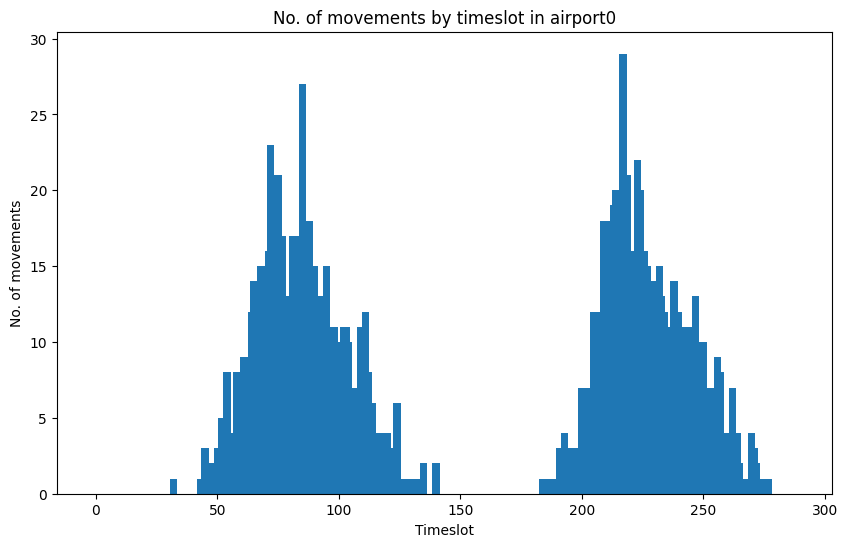

no of request:  1500


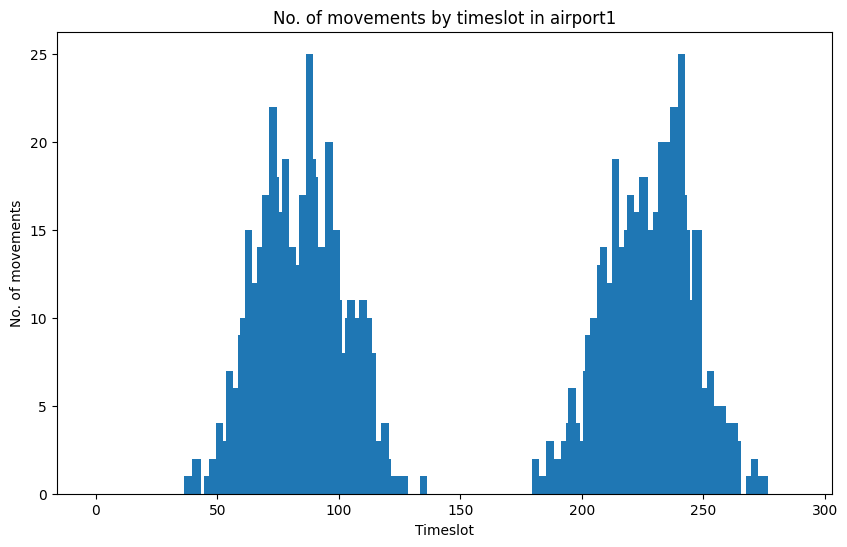

Number of violation for airport1:  104
Number of violation for airport2:  98
Action taken:  0
Number of unaccomodated requests at the start of this step: 1500
Original departure timeslot for request :  79
Original arrival timeslot for request :  91
New departure timeslot for request :  79
New arrival timeslot for request :  91
Request information in full request list before action is taken [[264 79 list([0.0, 1.0]) list([1.0, 0.0]) 60 1 91.0 1]]
Initial departure time slot demand before action is taken:  13
Initial arrival time slot demand before action is taken:  7
New departure time slot demand before action is taken:  13
New arrival time slot demand before action is taken:  7
Initial departure time slot demand after action is taken:  13
Initial arrival time slot demand after action is taken:  7
New departure time slot demand after action is taken:  13
New arrival time slot demand after action is taken:  7
Initial departure time slot remaining capacity before action is taken:  -7
Ini

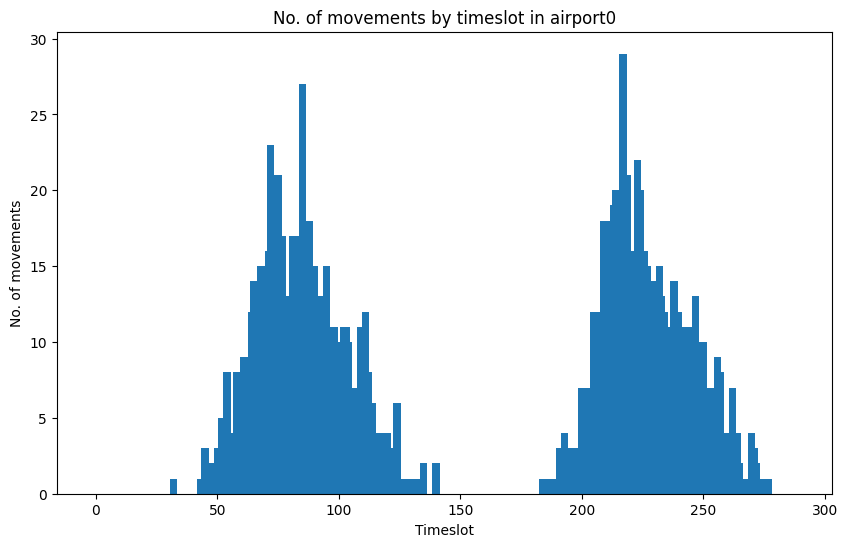

no of request:  1500


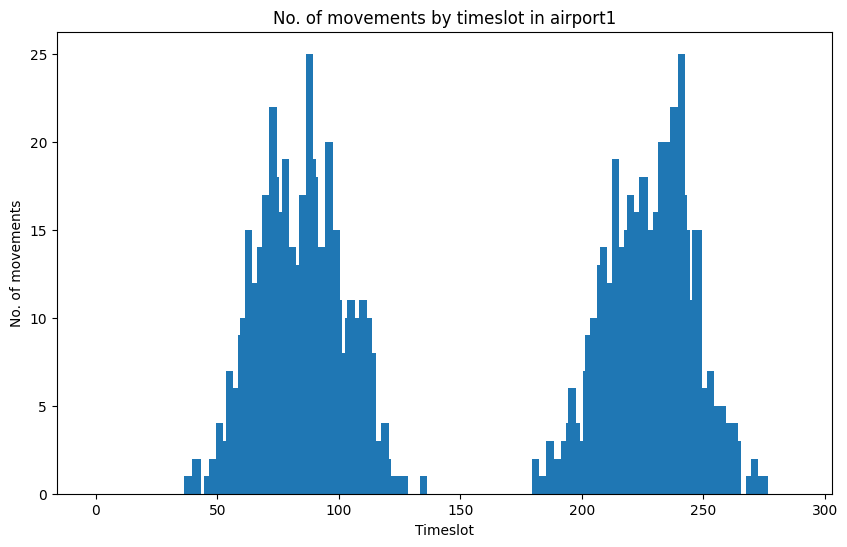

Initial count of unit violation for airport1 is:  104
Initial count of unit violation for airport2 is:  98
Final count of unit violation for airport1 is:  103
Final count of unit violation for airport2 is:  98
Total schedule delay of airport1 is:  23623.0
Total schedule delay of airport2 is:  20409
Max shift of airport1:  73.0
Max shift of airport2:  61
Number of unaccommodated requests:  1500
no of request:  1500


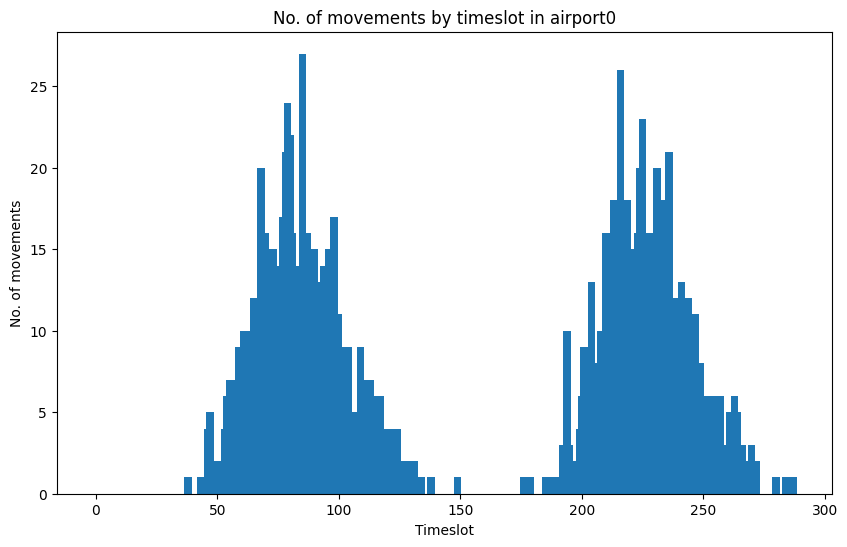

no of request:  1500


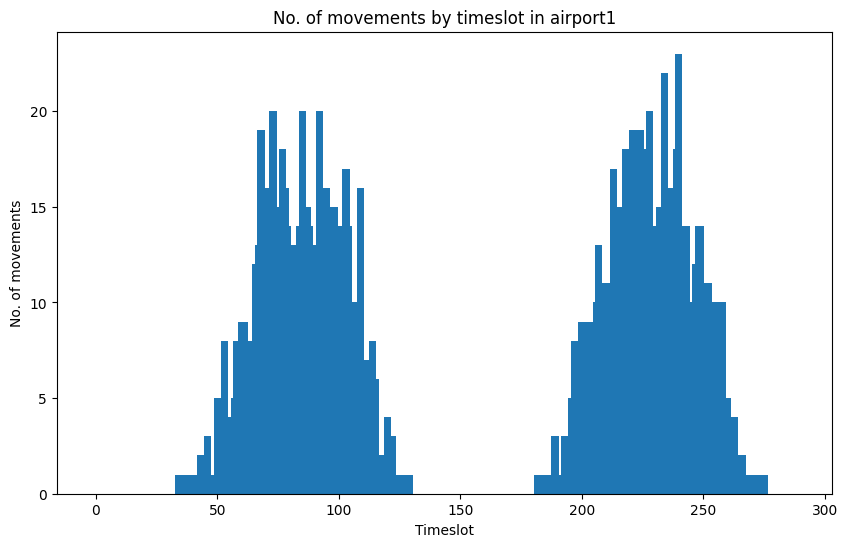

Number of violation for airport1:  96
Number of violation for airport2:  104
Action taken:  1
Number of unaccomodated requests at the start of this step: 1500
Original departure timeslot for request :  63
Original arrival timeslot for request :  87
New departure timeslot for request :  64
New arrival timeslot for request :  88
Request information in full request list before action is taken [[196 63 list([1.0, 0.0]) list([0.0, 1.0]) 120 1 87.0 1]]
Initial departure time slot demand before action is taken:  10
Initial arrival time slot demand before action is taken:  15
New departure time slot demand before action is taken:  10
New arrival time slot demand before action is taken:  14
Initial departure time slot demand after action is taken:  9
Initial arrival time slot demand after action is taken:  14
New departure time slot demand after action is taken:  11
New arrival time slot demand after action is taken:  15
Initial departure time slot remaining capacity before action is taken:  -4

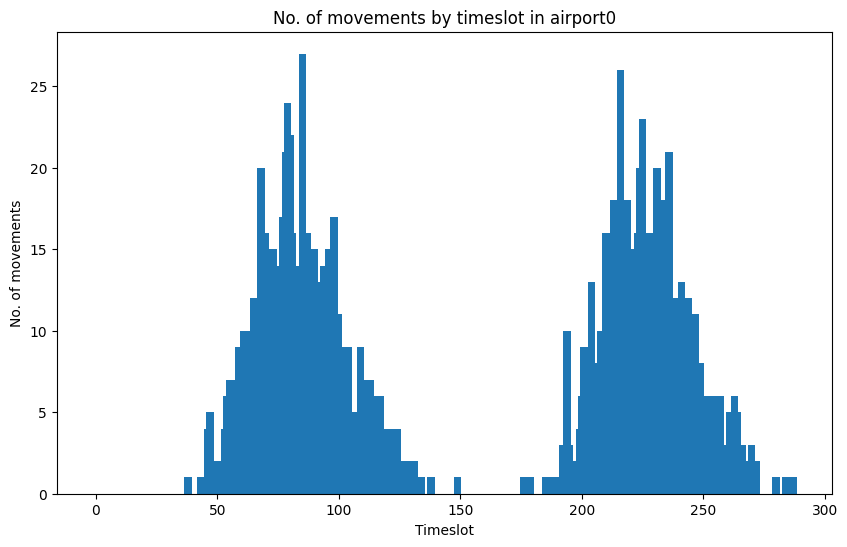

no of request:  1500


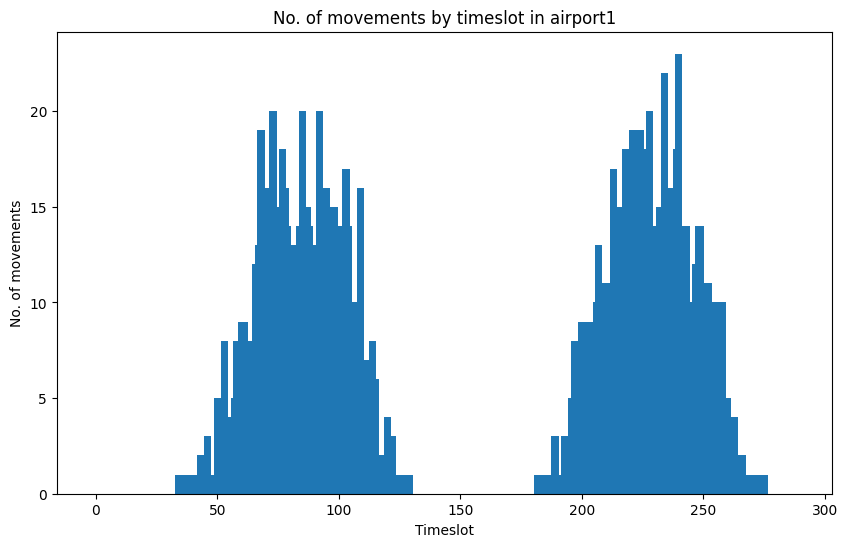

Initial count of unit violation for airport1 is:  96
Initial count of unit violation for airport2 is:  104
Final count of unit violation for airport1 is:  97
Final count of unit violation for airport2 is:  103
Total schedule delay of airport1 is:  19890
Total schedule delay of airport2 is:  23670.0
Max shift of airport1:  58
Max shift of airport2:  75.0
Number of unaccommodated requests:  1499

 ----------------------------Episode End-----------------------------



In [27]:
# Validate the environment
import time

def test_dqn(n_episodes=5, max_t=10, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_central_agent = []                 # scores for central_agent
    episode_lengths_central_agent = []        # episode lengths for central_agent
    scores_window_central_agent = deque(maxlen=100)  # last 100 scores for central_agent
    _final_violate_airport1_list = []
    _final_violate_airport2_list = []
    _max_shift_dep_list = []
    _max_shift_arv_list = []
    epsilons = []  # List to store epsilon values for the final episode

    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score_central_agent = 0
        episode_length_central_agent = 0
        start_time = time.time()

        for t in range(max_t):
            central_action = central_agent.act(state, eps)
            next_state, reward, done, _ = env.step(central_action)

            central_agent.step(state, central_action, reward, next_state, done)
            score_central_agent += reward
            episode_length_central_agent += 1
            
            state = next_state

            print("\n---------------------------------------------------------\n")
            
            if done:
                break

        epsilons.append(eps)
        scores_window_central_agent.append(score_central_agent)
        scores_central_agent.append(score_central_agent)
        episode_lengths_central_agent.append(episode_length_central_agent)

        _initial_violate_airport1, _initial_violate_airport2, _final_violate_airport1, _final_violate_airport2, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req = env.evaluate_metrics()
        _final_violate_airport1_list.append(_final_violate_airport1)
        _final_violate_airport2_list.append(_final_violate_airport2)
        _max_shift_dep_list.append(_max_shift_dep)
        _max_shift_arv_list.append(_max_shift_arv)

        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score Airport1: {:.2f}\t'.format(i_episode, np.mean(scores_window_central_agent)))

        # Save model parameters every 100 episodes
        if i_episode % 100 == 0:
            torch.save(central_agent.qnetwork_local.state_dict(), 'checkpoint_central_agent.pth')
            
    # Save model parameters at the end of the final episode
    torch.save(central_agent.qnetwork_local.state_dict(), 'final_checkpoint_central_agent.pth')

    print("\n ----------------------------Episode End-----------------------------\n")
    
    return scores_central_agent, episode_lengths_central_agent, _final_violate_airport1_list, _final_violate_airport2_list, _max_shift_dep_list, _max_shift_arv_list, epsilons

central_agent = Agent(state_size=578, action_size=num_actions, seed=0)

scores_central_agent, episode_lengths_central_agent, _final_violate_airport1_list, _final_violate_airport2_list, _max_shift_dep_list, _max_shift_arv_list, epsilons = test_dqn()

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------